# Ground-roll attenuation model with attention. 1D
## Attention branch as regression of noise mask parameters

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/gazprom-neft/SeismicPro/blob/master/datasets/ground-roll_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Required imports:

In [21]:
import sys
sys.path.append('../..')

import warnings
warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import shutil
import pprint

import numpy as np
from scipy import signal
import pandas as pd

from tqdm import tqdm


import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import patches


from seismicpro.batchflow import Pipeline, V, B, L, I, W

from seismicpro.batchflow.batchflow.models.tf import UNet, VGG7, VGG16
from seismicpro.batchflow.batchflow.models.tf.nn.activations import h_sigmoid

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import attention_loss_gauss


from Ground_Roll.src.utils import make_index, load_arrs
from Ground_Roll.src.unet_att2_params import UnetAttParams

%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


Index dataset

In [2]:
!ls -lh /notebooks/data/H1_WZ/NA

total 3.7G
-rw-r--r-- 1 root root 1.9G Nov 14 08:01 1_NA-gr_input_DN01.sgy
-rw-r--r-- 1 root root 1.9G Nov 14 08:01 1_NA-gr_output_DN03.sgy


In [3]:
paths = dict(raw = '/notebooks/data/H1_WZ/NA/1_NA-gr_input_DN01.sgy',
             lift = '/notebooks/data/H1_WZ/NA/1_NA-gr_output_DN03.sgy',
             m1 = os.path.abspath('1_model_inference/H1_WZ_train_test_unet_att_params_1.sgy'),
             m3 = os.path.abspath('3_model_inference/H1_WZ_unet_att_params_model_noise.sgy'),
            )
components = list(sorted(paths.keys()))

index = make_index(paths, extra_headers=['offset'])
index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,m1,m1,m3,m3,lift,lift,raw,raw
FieldRecord,,,,,,,,,,
111906,326,1512,1,/notebooks/tonya/SeismicPro/SeismicPro/Ground_...,1,/notebooks/tonya/SeismicPro/SeismicPro/Ground_...,1,/notebooks/data/H1_WZ/NA/1_NA-gr_output_DN03.sgy,1,/notebooks/data/H1_WZ/NA/1_NA-gr_input_DN01.sgy
111906,3307,323,72478,/notebooks/tonya/SeismicPro/SeismicPro/Ground_...,72478,/notebooks/tonya/SeismicPro/SeismicPro/Ground_...,1062,/notebooks/data/H1_WZ/NA/1_NA-gr_output_DN03.sgy,1062,/notebooks/data/H1_WZ/NA/1_NA-gr_input_DN01.sgy
111906,3306,1288,72477,/notebooks/tonya/SeismicPro/SeismicPro/Ground_...,72477,/notebooks/tonya/SeismicPro/SeismicPro/Ground_...,1061,/notebooks/data/H1_WZ/NA/1_NA-gr_output_DN03.sgy,1061,/notebooks/data/H1_WZ/NA/1_NA-gr_input_DN01.sgy
111906,3306,398,72476,/notebooks/tonya/SeismicPro/SeismicPro/Ground_...,72476,/notebooks/tonya/SeismicPro/SeismicPro/Ground_...,1060,/notebooks/data/H1_WZ/NA/1_NA-gr_output_DN03.sgy,1060,/notebooks/data/H1_WZ/NA/1_NA-gr_input_DN01.sgy
111906,3305,1161,72475,/notebooks/tonya/SeismicPro/SeismicPro/Ground_...,72475,/notebooks/tonya/SeismicPro/SeismicPro/Ground_...,1059,/notebooks/data/H1_WZ/NA/1_NA-gr_output_DN03.sgy,1059,/notebooks/data/H1_WZ/NA/1_NA-gr_input_DN01.sgy


In [4]:
len(index)

101

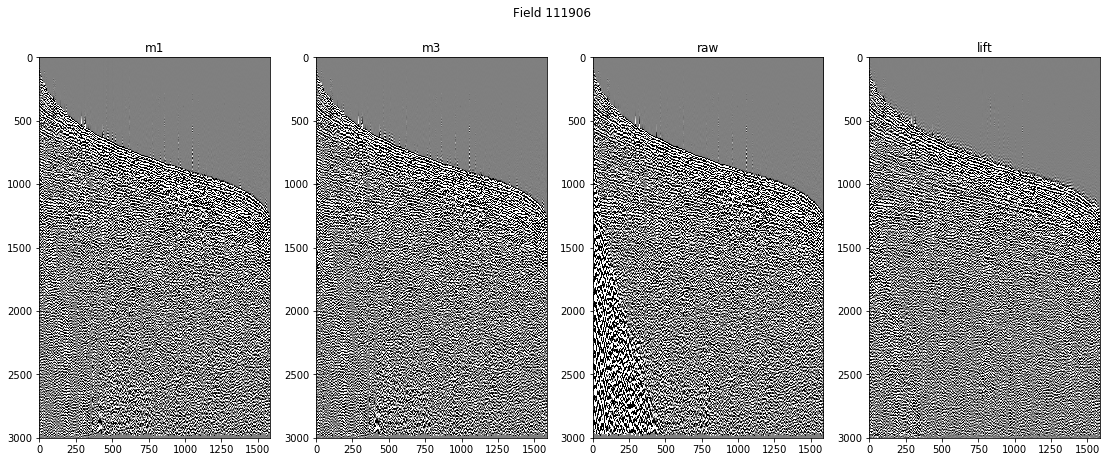

In [22]:
def check_res(i, index, cv=0.1):  
    
    arrs = load_arrs(i, index)   
    seismic_plot(list(arrs.values()), names=list(arrs.keys()),
                 figsize=(19, 7), cmap='gray', vmin=-cv, vmax=cv, title='Field {}'.format(index.indices[i]))
    
    return arrs

arrs = check_res(0, index)

Run test pipeline:

In [6]:
lift = arrs['lift']
raw = arrs['raw']
m1 = arrs['m1']
m3 = arrs['m3']
arrs.keys()

dict_keys(['m1', 'm3', 'raw', 'lift'])

In [7]:
def make_tiles(arr, hlen, vlen):
    # i, j - num parts to split
    
    x0, x1 = arr.shape
    
    i = x0//hlen
    j = x1//vlen
    splits = np.split(arr[:hlen*i], i)
    splits = [np.split(s[:,:vlen*j], j, axis=1) for s in splits]
    
    return splits

def assemble(splits):
    return np.vstack(np.hstack(l) for l in splits)

In [8]:
def corr_heatmap(arr, hlen, vlen, avg=False, dropna=True):
    splits = make_tiles(arr, hlen, vlen)
    corrs = [[np.corrcoef(t) - np.eye(t.shape[0]) for t in l] for l in splits]
    if avg:
        corrs = [[np.abs(np.nanmean(c) if dropna else np.mean(c)) for c in l] for l in corrs]
    return(assemble(corrs))
    

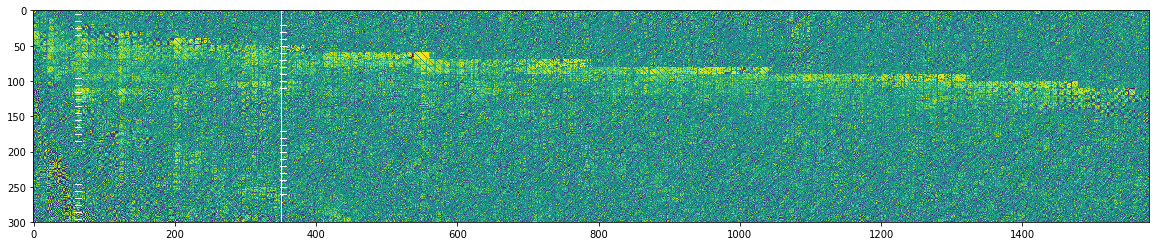

In [9]:
plt.figure( figsize=(20,20))
tmp = corr_heatmap(raw, 10, 100)
plt.imshow(tmp.T)

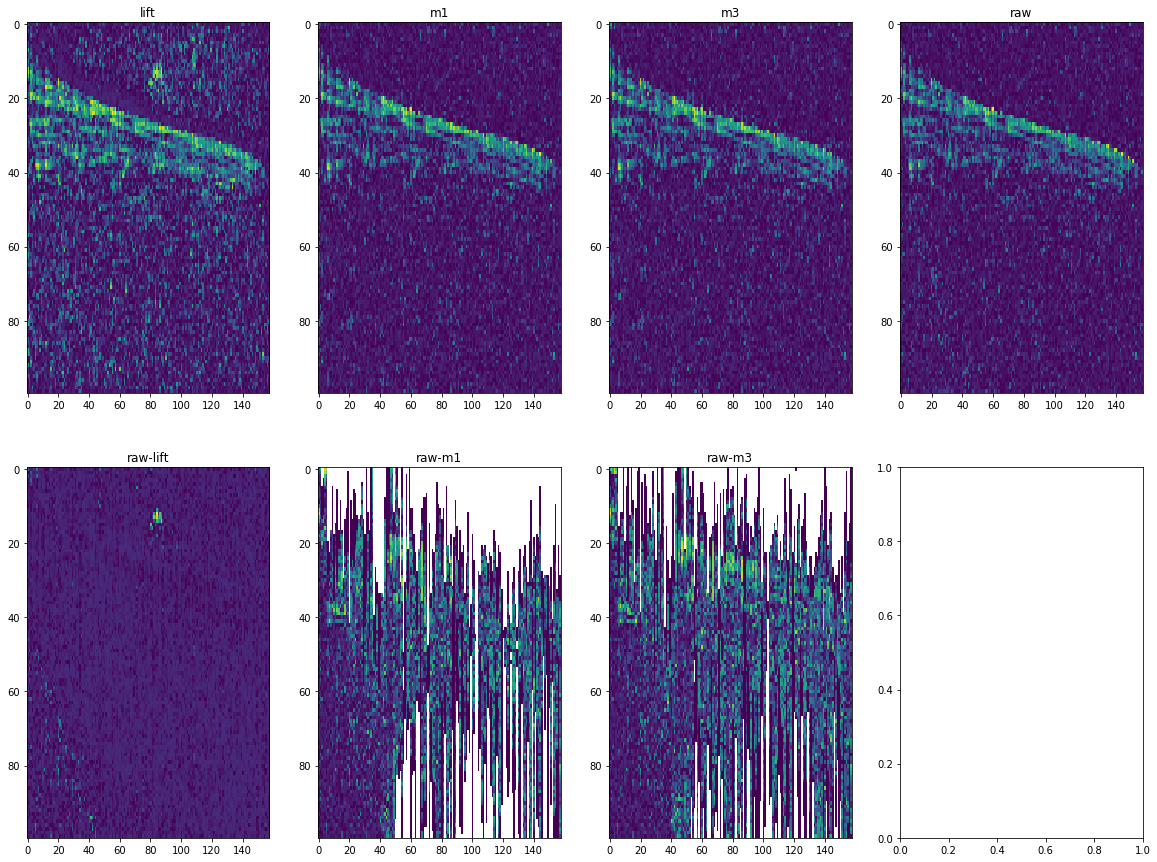

In [10]:
data = {'lift': lift, 'm1': m1, 'm3': m3, 'raw': raw, 'raw-lift': raw-lift, 'raw-m1': raw-m1, 'raw-m3': raw-m3}
fig, ax = plt.subplots(2, np.ceil(len(data)/2).astype(int), figsize=(20,15))

ax = ax.flatten()
for i, (title, arr) in enumerate(sorted(data.items())): 
    tmp = corr_heatmap(arr, 10, 30, avg=True)
    ax[i].imshow(tmp.T, vmin=0)
    ax[i].set_title(title)
    ax[i].set_aspect('auto')
    


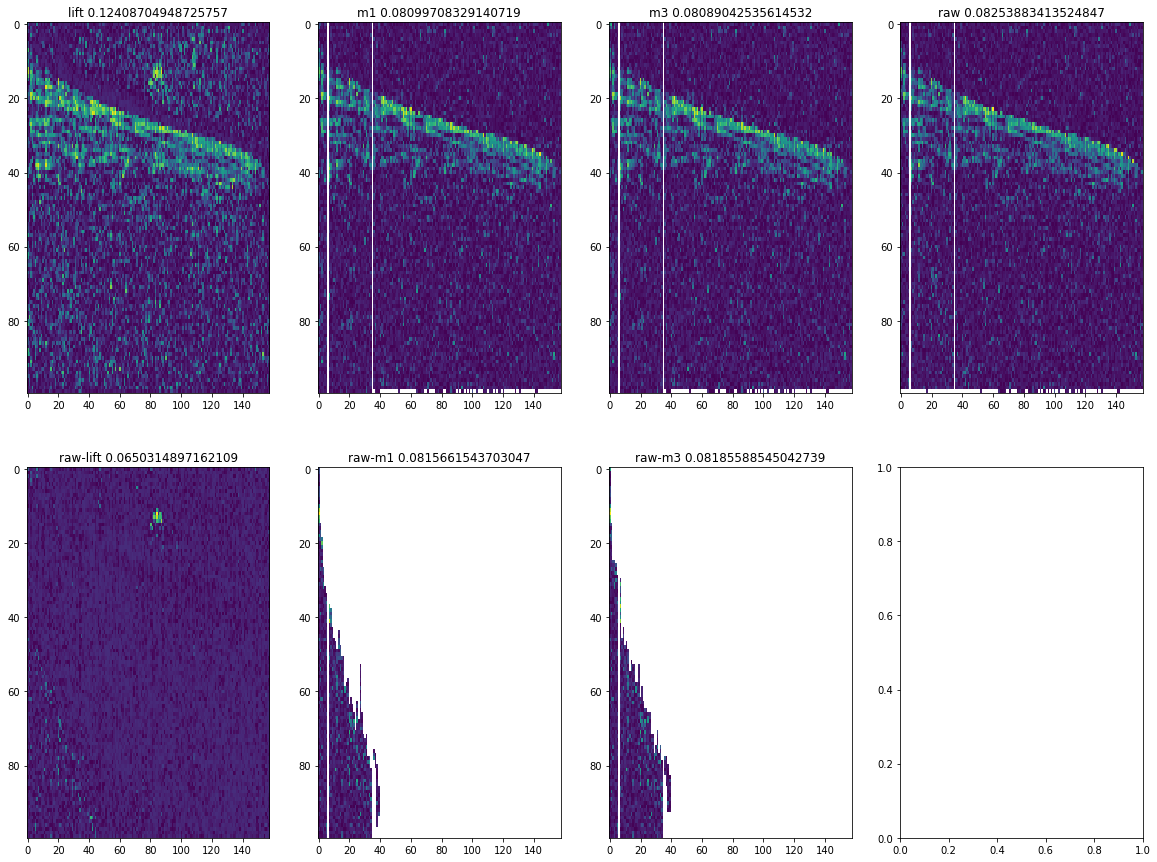

In [11]:
data = {'lift': lift, 'm1': m1, 'm3': m3, 'raw': raw, 'raw-lift': raw-lift, 'raw-m1': raw-m1, 'raw-m3': raw-m3}
fig, ax = plt.subplots(2, np.ceil(len(data)/2).astype(int), figsize=(20,15))

ax = ax.flatten()
for i, (title, arr) in enumerate(sorted(data.items())): 
    tmp = corr_heatmap(arr, 10, 30, avg=True, dropna=False)
    ax[i].imshow(tmp.T, vmin=0)
    ax[i].set_title(title + ' ' + str(np.nanmean(tmp)))
    ax[i].set_aspect('auto')

In [30]:
def get_windowed_spectrogram_dists(smgr, smgl, dist_fn='sum_abs',
                                   time_frame_width=100, noverlap=None, window='boxcar'):
    """
    Calculates distances between traces' spectrograms in sliding windows

    Parameters
    ----------
    smgr, smgl : np.array of shape (traces count, timestamps)
        traces to compute spectrograms on

    dist_fn : 'max_abs', 'sum_abs', 'sum_sq' or callable, optional
        function to calculate distance between 2 specrograms for single trace and single time window
        if callable, should accept 2 arrays of shape (traces count, frequencies, segment times)
        and operate on second axis
        Default is 'sum_abs'

    time_frame_width : int, optional
        nperseg for signal.spectrogram
        see ::meth:: scipy.signal.spectrogram

    noverlap : int, optional
        see ::meth:: scipy.signal.spectrogram

    window : str or tuple or array_like, optional
        see ::meth:: scipy.signal.spectrogram

    Returns
    -------
    np.array of shape (traces count, segment times) with distance heatmap
    """
    kwargs = dict(window=window, nperseg=time_frame_width, noverlap=noverlap, mode='complex')
    *_, spgl = signal.spectrogram(smgl, **kwargs)
    *_, spgr = signal.spectrogram(smgr, **kwargs)

    funcs = {
        'max_abs': lambda spgl, spgr: np.abs(spgl - spgr).max(axis=1),
        'sum_abs': lambda spgl, spgr: np.sum(np.abs(spgl - spgr), axis=1),
        'sum_sq': lambda spgl, spgr: np.sum(np.abs(spgl - spgr) ** 2, axis=1)
    }
    a_l = np.abs(spgl) ** 2 * 2
    a_r = np.abs(spgr) ** 2 * 2

    if callable(dist_fn):  # res(sl, sr)
        res_a = dist_fn(a_l, a_r)
    elif dist_fn in funcs:
        res_a = funcs[dist_fn](a_l, a_r)
    else:
        raise NotImplementedError('modes other than max_abs, sum_abs, sum_sq not implemented yet')

    return res_a


def draw_modifications_dist(modifications, traces_frac=0.1, distances='sum_abs',  # pylint: disable=too-many-arguments
                            vmin=None, vmax=None, figsize=(15, 15),
                            time_frame_width=100, noverlap=0, window='boxcar',
                            n_cols=None, fontsize=20, aspect=None,
                            save_to=None):
    """
    Draws seismograms with distances computed relative to 1-st given seismogram

    Parameters
    ----------
    modifications : list of tuples (np.array, str)
        each tuple represents a seismogram and its label
        traces in seismograms should be ordered by absolute offset increasing

    traces_frac : float, optional
        fraction of traces to use to compute metrics

    distances : list of str or callables, or str, or callable, optional
        dist_fn to pass to get_windowed_spectrogram_dists
        if list is given, all corresponding metrics values are computed

    vmin, vmax, figsize :
        parameters to pass to pyplot.imshow

    time_frame_width, noverlap, window :
        parameters to pass to get_windowed_spectrogram_dists

    n_cols : int or None, optional
        If int, resulting plots are arranged in n_cols collumns, and several rows, if needed
        if None, resulting plots are arranged in one row

    fontsize : int
        fontsize to use in Axes.set_title

    aspect : 'equal', 'auto', or None
        aspect to pass to Axes.set_aspect. If None, set_aspect is not called
    """

    x, y = 1, len(modifications)
    if n_cols is not None:
        x, y = int(np.ceil(y / n_cols)), n_cols

    _, axs = plt.subplots(x, y, figsize=figsize)

    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    axs = axs.flatten()

    origin, _ = modifications[0]
    n_traces, n_ts = origin.shape
    n_use_traces = int(n_traces*traces_frac)

    if isinstance(distances, str) or callable(distances):
        distances = (distances, )

    for i, (mod, description) in enumerate(modifications):
        distances_strings = []
        for dist_fn in distances:
            dist_a = get_windowed_spectrogram_dists(mod[0:n_use_traces], origin[0:n_use_traces],
                                                    dist_fn=dist_fn, time_frame_width=time_frame_width,
                                                    noverlap=noverlap, window=window)

            distances_strings.append(r"$\mu$={:.4}".format(np.mean(dist_a)))

        axs[i].imshow(mod.T, vmin=vmin, vmax=vmax, cmap='gray')
        rect = patches.Rectangle((0, 0), n_use_traces, n_ts, edgecolor='r', facecolor='none', lw=1)
        axs[i].add_patch(rect)
        axs[i].set_title("{},\n{}".format(description, '\n'.join(distances_strings)),
                         fontsize=fontsize)
        if aspect:
            axs[i].set_aspect(aspect)

    if save_to:
        plt.savefig(save_to, transparent=True)

    plt.show()

def validate_all(index, traces_frac=0.1, distance='sum_abs',
                 time_frame_width=100, noverlap=None, window='boxcar'):
    """ get metrics for all fields in batch """
    res = []

    for i in tqdm(range(len(index))):
        res.append({})
        
        arrs = load_arrs(i, index)
        modifications = [(arrs[t], t) for t in sorted(arrs)]        

        origin, _ = modifications[0]
        n_traces, _ = origin.shape
        n_use_traces = int(n_traces*traces_frac) if traces_frac <= 1 else min(int(traces_frac), n_traces)

        for mod, description in modifications:
            dist_a = get_windowed_spectrogram_dists(mod[0:n_use_traces], origin[0:n_use_traces],
                                                    dist_fn=distance, time_frame_width=time_frame_width,
                                                    noverlap=noverlap, window=window)
            res[i][description] = np.mean(dist_a)

    return res

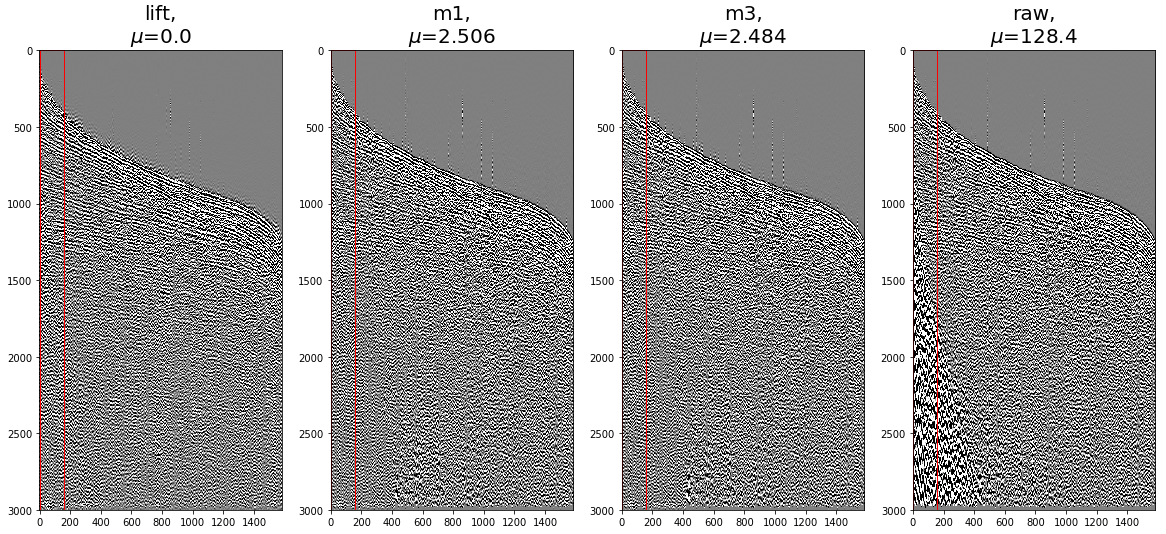

In [24]:
draw_modifications_dist([(lift,'lift'), (m1, 'm1'), (m3, 'm3'), (raw, 'raw')], vmin=-0.1, vmax=0.1, figsize=(20, 10))

In [25]:
res = validate_all(index)

100%|██████████| 101/101 [03:08<00:00,  1.87s/it]


In [28]:
df = pd.DataFrame(res)
df.mean()

lift_amp      0.000000
m1_amp        2.486241
m3_amp        2.735167
raw_amp     193.735271
dtype: float64

In [29]:
df['train']=0
df.iloc[:20]['train']=1

df.groupby('train').mean()

,lift_amp,m1_amp,m3_amp,raw_amp
train,,,,
0,0.0,2.673567,2.979954,208.042683
1,0.0,1.727574,1.743779,135.790253


In [31]:
res = validate_all(index, traces_frac=200)

100%|██████████| 101/101 [03:11<00:00,  1.89s/it]


In [32]:
df = pd.DataFrame(res)
df.mean()

lift      0.000000
m1        2.476604
m3        2.677382
raw     160.438701
dtype: float64

In [33]:
df['train']=0
df.iloc[:20]['train']=1

df.groupby('train').mean()

,lift,m1,m3,raw
train,,,,
0,0.0,2.686936,2.934359,170.319649
1,0.0,1.624760,1.636623,120.420860
